w_int min: -121.0, max: 127.0
zp_w: 0


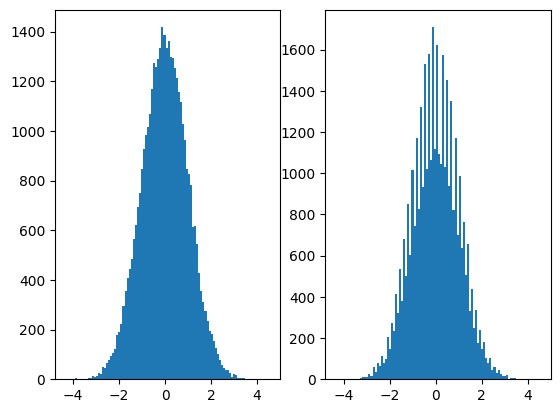

diff: 2.0421409606933594


In [41]:
"""
symmetric quantization


y = w * a + b

s_y, s_w, s_a
"""
import torch
import matplotlib.pyplot as plt

torch.random.manual_seed(0)

w_fp = torch.randn(197, 197)


s_w = w_fp.abs().max() / 127
zp_w = 0
w_int = (
    torch.clamp((w_fp / s_w).round() + zp_w, -128, 127).to(torch.int8).to(torch.float32)
)

print(f"w_int min: {w_int.min()}, max: {w_int.max()}")
print(f"zp_w: {zp_w}")
w_hat = (w_int - zp_w) * s_w


fig, ax = plt.subplots(1, 2)
ax[0].hist(w_fp.flatten().numpy(), bins=100)
ax[1].hist(w_hat.flatten().numpy(), bins=100)
plt.show()
print(f"diff: {torch.norm(w_fp - w_hat)}")

a_int : -102.0, 127.0
zp_a : 0


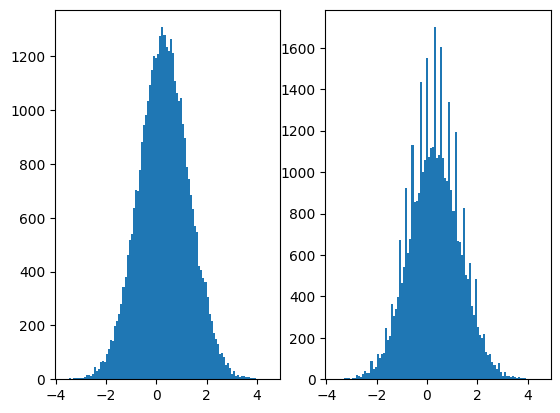

diff : 2.026183605194092


In [42]:
a_fp = torch.randn(197, 197) + 0.3

s_a = a_fp.abs().max() / 127
zp_a = 0

a_int = (
    torch.clamp((a_fp / s_a).round() + zp_a, -128, 127).to(torch.int8).to(torch.float32)
)

print(f"a_int : {a_int.min()}, {a_int.max()}")
a_hat = (a_int - zp_a) * s_a

print(f"zp_a : {zp_a}")

fig, ax = plt.subplots(1, 2)
ax[0].hist(a_fp.flatten().numpy(), bins=100)
ax[1].hist(a_hat.flatten().numpy(), bins=100)
plt.show()
print(f"diff : {torch.norm(a_fp - a_hat)}")

In [43]:
bias_fp = torch.tensor(2.4)
print(f"bias_fp : {bias_fp.min()}, {bias_fp.max()}")
bias_int = torch.round(bias_fp / s_w / s_a)
print(f"bias_int : {bias_int.min()}, {bias_int.max()}")

bias_fp : 2.4000000953674316, 2.4000000953674316
bias_int : 1878.0, 1878.0


w_ : -121.0, 127.0
a_ : -102.0, 127.0
accumulator : -44407.0, 55781.0
output_fp : -56.74554443359375, 71.27982330322266
diff : 41.315067291259766


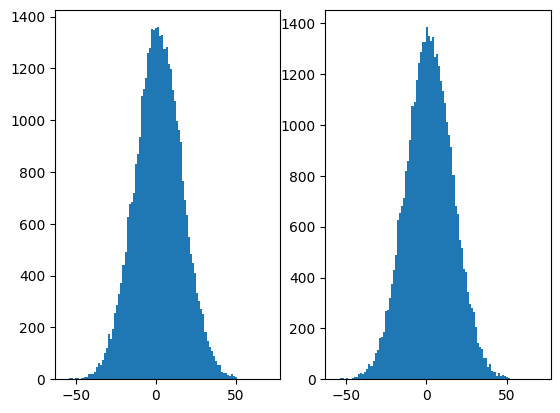

In [44]:
orgfpout = torch.matmul(w_fp, a_fp) + bias_fp

w_ = w_int
a_ = a_int

print(f"w_ : {w_.min()}, {w_.max()}")
print(f"a_ : {a_.min()}, {a_.max()}")
acc_int32 = torch.matmul(w_, a_) + bias_int
print(f"accumulator : {acc_int32.min()}, {acc_int32.max()}")
output_fp = acc_int32 * s_w * s_a
print(f"output_fp : {output_fp.min()}, {output_fp.max()}")


print(f"diff : {torch.norm(orgfpout - output_fp)}")

fig, ax = plt.subplots(1, 2)
ax[0].hist(orgfpout.flatten().numpy(), bins=100)
ax[1].hist(output_fp.flatten().numpy(), bins=100)
plt.show()

In [45]:
s_out_fp = output_fp.abs().max() / 127
zp_out_fp = 0
print(zp_out_fp)

print(s_w * s_a / s_out_fp)

dja = (
    torch.clamp((acc_int32 * 18 / 2**13) + zp_out_fp, -128, 127)
    .to(torch.int8)
    .to(torch.float32)
)
print(f"dja : {dja.min()}, {dja.max()}")

0
tensor(0.0023)
dja : -97.0, 122.0


In [46]:
18 / 2**13

0.002197265625

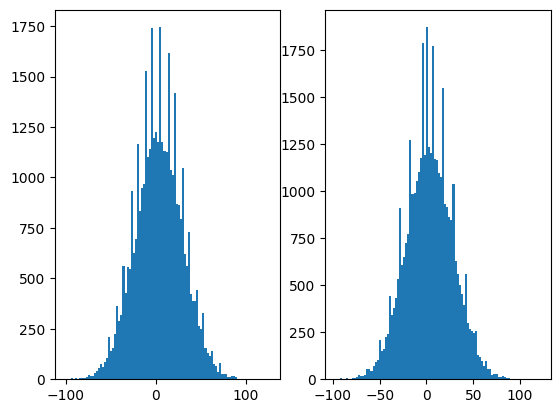

diff : 267.9944152832031


In [47]:
s_orgfpout = orgfpout.abs().max() / 127
zp_orgfpout = 0

orgfpout_int = (
    torch.clamp((orgfpout / s_orgfpout).round() + zp_orgfpout, -128, 127)
    .to(torch.int8)
    .to(torch.float32)
)


fig, ax = plt.subplots(1, 2)

ax[0].hist(orgfpout_int.flatten().numpy(), bins=100)
ax[1].hist(dja.flatten().numpy(), bins=100)
plt.show()

print(f"diff : {torch.norm(orgfpout_int - dja)}")

In [48]:
""" return 

data : dja : -128.0, 127.0
pre-layer's scaler : s_out_fp
pre-layer's bias : zp_out_fp

"""

" return \n\ndata : dja : -128.0, 127.0\npre-layer's scaler : s_out_fp\npre-layer's bias : zp_out_fp\n\n"